In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Dict, List, Any, Optional
from langchain_core.messages import HumanMessage
import json
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os
load_dotenv()
llm_key = os.getenv('llm_key')

In [3]:
model=ChatOpenAI(model="openai/gpt-oss-20b:free",
                        api_key=llm_key,
                        base_url="https://openrouter.ai/api/v1")

In [4]:
class GraphState(TypedDict):
    user_request: str
    workflow_analysis: Dict[str, Any]
    approval_chain: List[Dict[str, Any]]
    form_schema: Dict[str, Any]
    excel_schema: Dict[str, Any]
    workflow: Dict[str, Any]
    master_json: Dict[str, Any]
    sanity_check: Dict[str, Any]
    sanity_issues: List[str]
    regeneration_count: int

In [5]:
def analyze_request(state: GraphState):
    """
    Parse structured user input into workflow components
    """
    
    lines = state['user_request'].strip().split('\n')
    workflow_title = lines[0].strip() if len(lines) > 0 else "University Workflow"
    
    # Parse approval chain
    approval_sequence = []
    if len(lines) > 1:
        chain_line = lines[1].strip().lower()
        parts = [p.strip() for p in chain_line.replace(' to ', '|').split('|')]
        approval_sequence = [p for p in parts if p and p != 'student']
    
    # Parse additional requirements
    additional_reqs = []
    if len(lines) > 2:
        additional_reqs = [line.strip() for line in lines[2:] if line.strip()]
    
    # Build approval chain
    approval_chain = []
    for idx, role in enumerate(approval_sequence, 1):
        role_title = role.title()
        rejection_behavior = "end_workflow"
        notification_rules = []
        
        for req in additional_reqs:
            if "reject" in req.lower() and "director" in req.lower():
                notification_rules.append("notify director on rejection")
                rejection_behavior = "notify_director"
        
        approval_chain.append({
            "level": idx,
            "approver_role": role_title,
            "approver_type": "single",
            "source": "from_form",
            "conditions": [f"Level {idx} approver", "Can approve/reject with comments"],
            "rejection_behavior": rejection_behavior,
            "notification_rules": notification_rules,
            "timeout_hours": 48
        })
    
    # Determine form fields
    data_fields = [
        {
            "field_name": "submitter_name",
            "label": "Your Full Name",
            "type": "text",
            "required": True,
            "validation": "string"
        },
        {
            "field_name": "submitter_email",
            "label": "Your Email",
            "type": "email",
            "required": True,
            "validation": "email"
        },
        {
            "field_name": "submitter_id",
            "label": "Your ID Number",
            "type": "text",
            "required": True,
            "validation": "string"
        },
        {
            "field_name": "request_details",
            "label": "Request Details",
            "type": "textarea",
            "required": True,
            "validation": "minimum_50_characters"
        }
    ]
    
    # Add approver fields
    for role in approval_sequence:
        role_field = role.title().replace(" ", "_")
        data_fields.extend([
            {
                "field_name": f"{role_field.lower()}_name",
                "label": f"{role.title()} Name",
                "type": "text",
                "required": True,
                "purpose": "approver_identification"
            },
            {
                "field_name": f"{role_field.lower()}_email",
                "label": f"{role.title()} Email",
                "type": "email",
                "required": True,
                "purpose": "approver_contact"
            }
        ])
    
    # Build notifications
    notifications = [
        {
            "trigger": "form_submitted",
            "recipients": ["submitter", "first_approver"],
            "platform": "Outlook",
            "template": "confirmation"
        },
        {
            "trigger": "approval_at_any_level",
            "recipients": ["submitter", "next_approver"],
            "platform": "Outlook",
            "template": "approval_progress"
        },
        {
            "trigger": "final_approval",
            "recipients": ["submitter", "all_approvers"],
            "platform": "Outlook",
            "template": "final_decision"
        }
    ]
    
    if any("reject" in req.lower() and "director" in req.lower() for req in additional_reqs):
        notifications.append({
            "trigger": "rejection_at_any_level",
            "recipients": ["submitter", "director"],
            "platform": "Outlook",
            "template": "rejection_notice",
            "special_rule": "director must be notified of all rejections"
        })
    
    analysis = {
        "workflow_name": workflow_title,
        "workflow_description": f"Automated approval workflow for {workflow_title.lower()}",
        "approval_chain": approval_chain,
        "data_to_collect": data_fields,
        "notifications": notifications,
        "business_rules": [
            f"Approval chain: {' → '.join([r.title() for r in approval_sequence])}",
            "All approvals via Microsoft Teams Approvals",
            "All tracking in Excel SharePoint table",
            "All emails via Outlook",
            "End user provides approver details via form"
        ] + additional_reqs,
        "platform_requirements": {
            "form_platform": "Microsoft Forms",
            "tracking_platform": "Excel Online (Business)",
            "approval_platform": "Microsoft Teams - Approvals",
            "email_platform": "Office 365 Outlook"
        }
    }
    
    print("\n🔍 WORKFLOW ANALYSIS COMPLETE")
    print(f"   Workflow: {analysis['workflow_name']}")
    print(f"   Approval Chain: {' → '.join([a['approver_role'] for a in approval_chain])}")
    print(f"   Approval Levels: {len(approval_chain)}")
    print(f"   Form Fields: {len(data_fields)}")
    
    return {
        "workflow_analysis": analysis,
        "approval_chain": approval_chain
    }


In [6]:
def generate_form_schema(state: GraphState):
    """
    Generate Microsoft Forms schema
    """
    
    analysis = state.get("workflow_analysis", {})
    data_fields = analysis.get("data_to_collect", [])
    
    form_schema = {
        "title": analysis.get("workflow_name", "Workflow Form"),
        "description": analysis.get("workflow_description", ""),
        "platform": "Microsoft Forms",
        "settings": {
            "one_response_per_user": True,
            "allow_anonymous": False,
            "confirmation_message": "Your request has been submitted successfully!"
        },
        "questions": []
    }
    
    for idx, field in enumerate(data_fields, 1):
        form_schema["questions"].append({
            "id": f"q{idx}",
            "field_name": field["field_name"],
            "type": field["type"],
            "title": field["label"],
            "required": field["required"],
            "validation": field.get("validation", ""),
            "purpose": field.get("purpose", "user_data")
        })
    
    print(f"\n📋 Form Schema: {len(form_schema['questions'])} questions")
    
    return {"form_schema": form_schema}


In [7]:
def generate_excel_schema(state: GraphState):
    """
    Generate Excel tracking schema
    """
    
    analysis = state.get("workflow_analysis", {})
    approval_chain = state.get("approval_chain", [])
    form_schema = state.get("form_schema", {})
    
    columns = [
        {"name": "SubmissionID", "type": "text", "description": "Unique identifier"},
        {"name": "SubmissionTimestamp", "type": "datetime", "description": "Submission time"},
        {"name": "CurrentStatus", "type": "choice", 
         "choices": ["Submitted", "Pending", "Approved", "Rejected", "Withdrawn"]}
    ]
    
    # Add form field columns
    for question in form_schema.get("questions", []):
        columns.append({
            "name": question["field_name"],
            "type": "text",
            "description": f"From form: {question['title']}"
        })
    
    # Add approval tracking columns for each level
    for level_info in approval_chain:
        role = level_info["approver_role"].replace(" ", "_")
        columns.extend([
            {"name": f"{role}_Status", "type": "choice", 
             "choices": ["Pending", "Approved", "Rejected"]},
            {"name": f"{role}_Name", "type": "text"},
            {"name": f"{role}_Email", "type": "text"},
            {"name": f"{role}_Timestamp", "type": "datetime"},
            {"name": f"{role}_Comments", "type": "text"},
            {"name": f"{role}_TimeSpent_Hours", "type": "number"}
        ])
    
    columns.extend([
        {"name": "FinalDecision", "type": "choice", "choices": ["Approved", "Rejected"]},
        {"name": "FinalDecisionDate", "type": "datetime"},
        {"name": "TotalProcessingTime_Hours", "type": "number"}
    ])
    
    excel_schema = {
        "table_name": f"{analysis.get('workflow_name', '').replace(' ', '_')}_Tracker",
        "platform": "Excel Online (Business) - SharePoint",
        "location": "SharePoint/Shared Documents/Workflow Tracking",
        "file_name": f"{analysis.get('workflow_name', '').replace(' ', '_')}_Database.xlsx",
        "columns": columns,
        "views": [
            {"name": "Pending Approvals", "filter": "CurrentStatus = 'Pending'"},
            {"name": "Approved Requests", "filter": "CurrentStatus = 'Approved'"},
            {"name": "Recent Submissions", "filter": "SubmissionTimestamp >= TODAY() - 7"}
        ]
    }
    
    print(f"\n📊 Excel Schema: {len(columns)} columns")
    
    return {"excel_schema": excel_schema}

In [8]:
def generate_workflow(state: GraphState):
    """
    Generate Power Automate workflow
    """
    
    analysis = state.get("workflow_analysis", {})
    form_schema = state.get("form_schema", {})
    excel_schema = state.get("excel_schema", {})
    approval_chain = state.get("approval_chain", [])
    notifications = analysis.get("notifications", [])
    
    workflow = {
        "name": analysis.get("workflow_name", ""),
        "description": analysis.get("workflow_description", ""),
        "version": "1.0",
        "platform": "Microsoft Power Automate",
        "trigger": {
            "type": "Microsoft Forms",
            "operation": "When a new response is submitted",
            "form_name": form_schema.get("title", ""),
            "form_id": "{TO_BE_CONFIGURED}"
        },
        "variables": [
            {"name": "SubmissionID", "type": "String", "initial_value": "guid()"},
            {"name": "CurrentStatus", "type": "String", "initial_value": "Submitted"},
            {"name": "SubmissionTimestamp", "type": "DateTime", "initial_value": "utcNow()"},
            {"name": "ApprovalLevel", "type": "Integer", "initial_value": 0},
            {"name": "WorkflowTerminated", "type": "Boolean", "initial_value": False}
        ],
        "steps": []
    }
    
    step_num = 1
    
    # Step 1: Get form response
    workflow["steps"].append({
        "step_number": step_num,
        "step_id": "get_form_response",
        "name": "Get Form Response Details",
        "type": "action",
        "connector": "Microsoft Forms",
        "operation": "Get response details",
        "inputs": {
            "form_id": "{FORM_ID}",
            "response_id": "triggerBody()['resourceData']['id']"
        },
        "outputs": ["form_response_data"]
    })
    
    step_num += 1
    
    # Step 2: Create Excel tracking row
    workflow["steps"].append({
        "step_number": step_num,
        "step_id": "create_excel_row",
        "name": "Create Tracking Record in Excel",
        "type": "action",
        "connector": "Excel Online (Business)",
        "operation": "Add a row into a table",
        "inputs": {
            "location": "SharePoint",
            "document_library": excel_schema.get("location", ""),
            "file": excel_schema.get("file_name", ""),
            "table": excel_schema.get("table_name", ""),
            "row_data": {
                "SubmissionID": "variables('SubmissionID')",
                "SubmissionTimestamp": "variables('SubmissionTimestamp')",
                "CurrentStatus": "variables('CurrentStatus')",
                "submitter_name": "body('get_form_response')['submitter_name']",
                "submitter_email": "body('get_form_response')['submitter_email']"
            }
        }
    })
    
    step_num += 1
    
    # Step 3: Send confirmation email
    workflow["steps"].append({
        "step_number": step_num,
        "step_id": "send_confirmation",
        "name": "Send Submission Confirmation",
        "type": "action",
        "connector": "Office 365 Outlook",
        "operation": "Send an email (V2)",
        "inputs": {
            "to": "body('get_form_response')['submitter_email']",
            "subject": f"✅ {analysis.get('workflow_name', '')} - Submission Received",
            "body": "Your request has been submitted and is being processed.",
            "importance": "Normal"
        }
    })
    
    step_num += 1
    
    # Approval flow
    for level_info in approval_chain:
        role = level_info["approver_role"]
        level = level_info["level"]
        
        # Approval request via Teams
        workflow["steps"].append({
            "step_number": step_num,
            "step_id": f"approval_level_{level}",
            "name": f"Approval Request - {role}",
            "type": "action",
            "connector": "Microsoft Teams - Approvals",
            "operation": "Start and wait for an approval",
            "inputs": {
                "approval_type": "Approve/Reject - First to respond",
                "title": f"Approval Required - {analysis.get('workflow_name')}",
                "assigned_to": f"body('get_form_response')['{role.lower().replace(' ', '_')}_email']",
                "details": f"Please review and approve/reject this {analysis.get('workflow_name').lower()}",
                "item_link": "Flow run URL",
                "enable_comments": True,
                "enable_notifications": True
            },
            "timeout": {
                "duration_hours": level_info.get("timeout_hours", 48),
                "action": "send_reminder"
            }
        })
        
        step_num += 1
        
        # Update Excel with approval decision
        workflow["steps"].append({
            "step_number": step_num,
            "step_id": f"update_excel_level_{level}",
            "name": f"Update Excel - {role} Decision",
            "type": "action",
            "connector": "Excel Online (Business)",
            "operation": "Update a row",
            "inputs": {
                "table": excel_schema.get("table_name", ""),
                "key_column": "SubmissionID",
                "key_value": "variables('SubmissionID')",
                "updates": {
                    f"{role.replace(' ', '_')}_Status": f"body('approval_level_{level}')['outcome']",
                    f"{role.replace(' ', '_')}_Name": f"body('approval_level_{level}')['responder']['displayName']",
                    f"{role.replace(' ', '_')}_Email": f"body('approval_level_{level}')['responder']['email']",
                    f"{role.replace(' ', '_')}_Timestamp": "utcNow()",
                    f"{role.replace(' ', '_')}_Comments": f"body('approval_level_{level}')['comments']"
                }
            }
        })
        
        step_num += 1
        
        # Check for rejection
        workflow["steps"].append({
            "step_number": step_num,
            "step_id": f"check_rejection_level_{level}",
            "name": f"Check if {role} Rejected",
            "type": "condition",
            "condition": f"body('approval_level_{level}')['outcome'] equals 'Reject'",
            "if_yes": [
                {
                    "step_id": f"handle_rejection_level_{level}",
                    "name": "Handle Rejection",
                    "type": "action",
                    "connector": "Office 365 Outlook",
                    "operation": "Send an email (V2)",
                    "inputs": {
                        "to": "body('get_form_response')['submitter_email']",
                        "subject": f"❌ {analysis.get('workflow_name')} - Not Approved",
                        "body": f"Your request was not approved by {role}."
                    }
                },
                {
                    "step_id": "terminate_workflow",
                    "name": "Terminate Workflow",
                    "type": "action",
                    "operation": "Terminate",
                    "status": "Cancelled"
                }
            ],
            "if_no": [
                {
                    "step_id": f"continue_level_{level}",
                    "name": "Continue to Next Level",
                    "type": "action",
                    "operation": "Set variable",
                    "variable": "ApprovalLevel",
                    "value": level
                }
            ]
        })
        
        step_num += 1
    
    # Final approval notification
    workflow["steps"].append({
        "step_number": step_num,
        "step_id": "send_final_approval",
        "name": "Send Final Approval Notification",
        "type": "action",
        "connector": "Office 365 Outlook",
        "operation": "Send an email (V2)",
        "inputs": {
            "to": "body('get_form_response')['submitter_email']",
            "subject": f"✅ {analysis.get('workflow_name')} - APPROVED",
            "body": "Congratulations! Your request has been fully approved.",
            "importance": "High"
        }
    })
    
    workflow["notifications"] = notifications
    
    print(f"\n⚙️  Workflow: {len(workflow['steps'])} steps")
    
    return {"workflow": workflow}

In [9]:
def generate_master_json(state: GraphState):
    """
    Combine all components into master JSON
    """
    
    analysis = state.get("workflow_analysis", {})
    form_schema = state.get("form_schema", {})
    excel_schema = state.get("excel_schema", {})
    workflow = state.get("workflow", {})
    approval_chain = state.get("approval_chain", [])
    
    master_json = {
        "metadata": {
            "workflow_name": analysis.get("workflow_name", ""),
            "description": analysis.get("workflow_description", ""),
            "version": "1.0",
            "generated_at": "2024-12-03T00:00:00Z",
            "platform": "Microsoft 365",
            "components": ["Forms", "Teams", "Excel", "Outlook"]
        },
        "workflow_analysis": {
            "approval_chain": approval_chain,
            "business_rules": analysis.get("business_rules", []),
            "notifications": analysis.get("notifications", []),
            "platform_requirements": analysis.get("platform_requirements", {})
        },
        "microsoft_forms": form_schema,
        "excel_tracker": excel_schema,
        "power_automate_workflow": workflow,
        "deployment_instructions": {
            "step_1": "Import form schema to Microsoft Forms",
            "step_2": "Create Excel table in SharePoint using schema",
            "step_3": "Import workflow to Power Automate",
            "step_4": "Configure connections (Forms, Teams, Excel, Outlook)",
            "step_5": "Test with sample submission",
            "step_6": "Deploy to end users"
        }
    }
    
    print("\n✅ Master JSON generated")
    
    return {"master_json": master_json}

In [10]:
def sanity_check(state: GraphState):
    """
    Quick validation of generated components
    """
    
    print("\n🔍 Running sanity check...")
    
    issues = []
    master_json = state.get("master_json", {})
    
    if not master_json.get("metadata", {}).get("workflow_name"):
        issues.append("Missing workflow name")
    
    if not master_json.get("microsoft_forms", {}).get("questions"):
        issues.append("No form questions defined")
    
    if not master_json.get("excel_tracker", {}).get("columns"):
        issues.append("No Excel columns defined")
    
    if not master_json.get("power_automate_workflow", {}).get("steps"):
        issues.append("No workflow steps defined")
    
    if not issues:
        print("   ✅ All checks passed")
        return {
            "sanity_check": {"passed": True, "issues": []},
            "sanity_issues": []
        }
    else:
        print(f"   ❌ {len(issues)} issues found")
        for issue in issues:
            print(f"      • {issue}")
        return {
            "sanity_check": {"passed": False, "issues": issues},
            "sanity_issues": issues
        }

In [11]:
def display_output(state: GraphState):
    """
    Display the master JSON
    """
    
    master_json = state.get("master_json", {})
    sanity_check = state.get("sanity_check", {})
    
    print("\n" + "="*80)
    print("✅ WORKFLOW GENERATION COMPLETE")
    print("="*80)
    
    metadata = master_json.get("metadata", {})
    print(f"\n📋 {metadata.get('workflow_name', 'Workflow')}")
    print(f"📝 {metadata.get('description', '')}")
    
    print("\n🔧 COMPONENTS GENERATED:")
    print(f"   • Microsoft Forms: {len(master_json.get('microsoft_forms', {}).get('questions', []))} questions")
    print(f"   • Excel Tracker: {len(master_json.get('excel_tracker', {}).get('columns', []))} columns")
    print(f"   • Power Automate: {len(master_json.get('power_automate_workflow', {}).get('steps', []))} steps")
    
    if sanity_check.get("passed"):
        print("\n✅ Sanity Check: PASSED")
    else:
        print(f"\n⚠️  Sanity Check: {len(sanity_check.get('issues', []))} issues")
    
    print("\n" + "="*80)
    print("📄 MASTER JSON OUTPUT")
    print("="*80 + "\n")
    
    print(json.dumps(master_json, indent=2))
    
    print("\n" + "="*80)
    print("💾 You can now:")
    print("   • Copy the JSON above")
    print("   • Save to file")
    print("   • Import to Power Automate")
    print("="*80)
    
    return state

In [12]:
def build_workflow_graph():
    """
    Build simplified workflow graph
    """
    
    graph = StateGraph(GraphState)
    
    # Add nodes
    graph.add_node("analyze", analyze_request)
    graph.add_node("generate_form", generate_form_schema)
    graph.add_node("generate_excel", generate_excel_schema)
    graph.add_node("generate_workflow", generate_workflow)
    graph.add_node("create_master_json", generate_master_json)
    graph.add_node("sanity_check", sanity_check)
    graph.add_node("display", display_output)
    
    # Define flow
    graph.set_entry_point("analyze")
    graph.add_edge("analyze", "generate_form")
    graph.add_edge("generate_form", "generate_excel")
    graph.add_edge("generate_excel", "generate_workflow")
    graph.add_edge("generate_workflow", "create_master_json")
    graph.add_edge("create_master_json", "sanity_check")
    graph.add_edge("sanity_check", "display")
    graph.add_edge("display", END)
    
    return graph.compile()

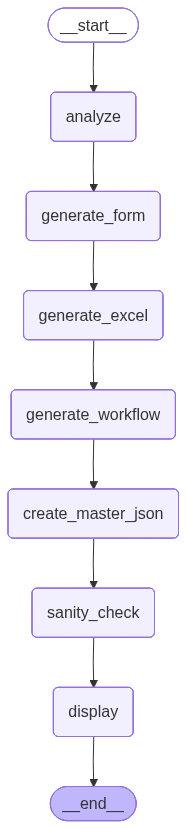

In [13]:
app = build_workflow_graph()
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [14]:
if __name__ == "__main__":
    print("="*80)
    print("🎓 WORKFLOW GENERATOR - JSON PROTOTYPE")
    print("="*80)
    print("\n📋 INPUT FORMAT:")
    print("Line 1: Workflow Title")
    print("Line 2: Approval Chain (A to B to C)")
    print("Line 3+: Additional Requirements\n")
    
    print("="*80)
    print("📝 EXAMPLE:")
    print("-"*80)
    print("""
Leave Letter Approval

Student to Mentor to Class Teacher to Director

Student provides all approver emails in the form.
Director notified on any rejection.
    """)
    print("="*80)
    
    # user_input = input("\n📝 Enter your workflow (or press Enter for example):\n\n").strip()
    
    # if not user_input:
    user_input = """Leave Letter Approval

Student to Mentor to Class Teacher to Director

Student provides all approver emails in the form.
Director notified on any rejection."""
    
    print("\n" + "="*80)
    print("🤖 Generating workflow...")
    print("="*80)
    
    # Initialize and run
    initial_state = {
        "user_request": user_input,
        "workflow_analysis": {},
        "approval_chain": [],
        "form_schema": {},
        "excel_schema": {},
        "workflow": {},
        "master_json": {},
        "sanity_check": {},
        "sanity_issues": [],
        "regeneration_count": 0
    }
    
    app = build_workflow_graph()
    
    try:
        final_state = app.invoke(initial_state)
        print("\n✅ SUCCESS - Master JSON generated above!")
    except Exception as e:
        print(f"\n❌ Error: {str(e)}")
        import traceback
        traceback.print_exc()

🎓 WORKFLOW GENERATOR - JSON PROTOTYPE

📋 INPUT FORMAT:
Line 1: Workflow Title
Line 2: Approval Chain (A to B to C)
Line 3+: Additional Requirements

📝 EXAMPLE:
--------------------------------------------------------------------------------

Leave Letter Approval

Student to Mentor to Class Teacher to Director

Student provides all approver emails in the form.
Director notified on any rejection.
    

🤖 Generating workflow...

🔍 WORKFLOW ANALYSIS COMPLETE
   Workflow: Leave Letter Approval
   Approval Chain: 
   Approval Levels: 0
   Form Fields: 4

📋 Form Schema: 4 questions

📊 Excel Schema: 10 columns

⚙️  Workflow: 4 steps

✅ Master JSON generated

🔍 Running sanity check...
   ✅ All checks passed

✅ WORKFLOW GENERATION COMPLETE

📋 Leave Letter Approval
📝 Automated approval workflow for leave letter approval

🔧 COMPONENTS GENERATED:
   • Microsoft Forms: 4 questions
   • Excel Tracker: 10 columns
   • Power Automate: 4 steps

✅ Sanity Check: PASSED

📄 MASTER JSON OUTPUT

{
  "metadat

In [16]:
final_state['workflow_analysis']

{'workflow_name': 'Leave Letter Approval',
 'workflow_description': 'Automated approval workflow for leave letter approval',
 'approval_chain': [],
 'data_to_collect': [{'field_name': 'submitter_name',
   'label': 'Your Full Name',
   'type': 'text',
   'required': True,
   'validation': 'string'},
  {'field_name': 'submitter_email',
   'label': 'Your Email',
   'type': 'email',
   'required': True,
   'validation': 'email'},
  {'field_name': 'submitter_id',
   'label': 'Your ID Number',
   'type': 'text',
   'required': True,
   'validation': 'string'},
  {'field_name': 'request_details',
   'label': 'Request Details',
   'type': 'textarea',
   'required': True,
   'validation': 'minimum_50_characters'}],
 'notifications': [{'trigger': 'form_submitted',
   'recipients': ['submitter', 'first_approver'],
   'platform': 'Outlook',
   'template': 'confirmation'},
  {'trigger': 'approval_at_any_level',
   'recipients': ['submitter', 'next_approver'],
   'platform': 'Outlook',
   'template'